In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import imodelsx.process_results
import sys
import numpy as np
import viz
import llm_tree.data
import imodelsx
import sklearn.tree
sys.path.append('../experiments/')
# results_dir = '../results/fmri_feb24/'
results_dir = '../results/fmri/'

# load results as dataframe
r = imodelsx.process_results.get_results_df(results_dir, use_cached=False)

# fill missing args with default values from argparse
experiment_filename = '../experiments/01_train_model.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)

# filter out trees that are too deep
# r = r[r.max_depth == 4]

# average over random seeds
group_keys = [
    k for k in imodelsx.process_results.get_main_args_list(experiment_filename)
    if not k == 'seed'
]
ravg = (
    r
    .groupby(by=group_keys)
    .mean(numeric_only=True)
    .reset_index()
)

groupings = ['model_name', 'label_name'] 
ravg_cv = (
    ravg
    .sort_values(by='corr_cv', ascending=False)
    .groupby(by=groupings)
    .first()  # selects best max_depth
    .reset_index()
)

100%|██████████| 1049/1049 [00:02<00:00, 364.54it/s]


### Performance table

decision_tree 0.96
llm_tree 0.97


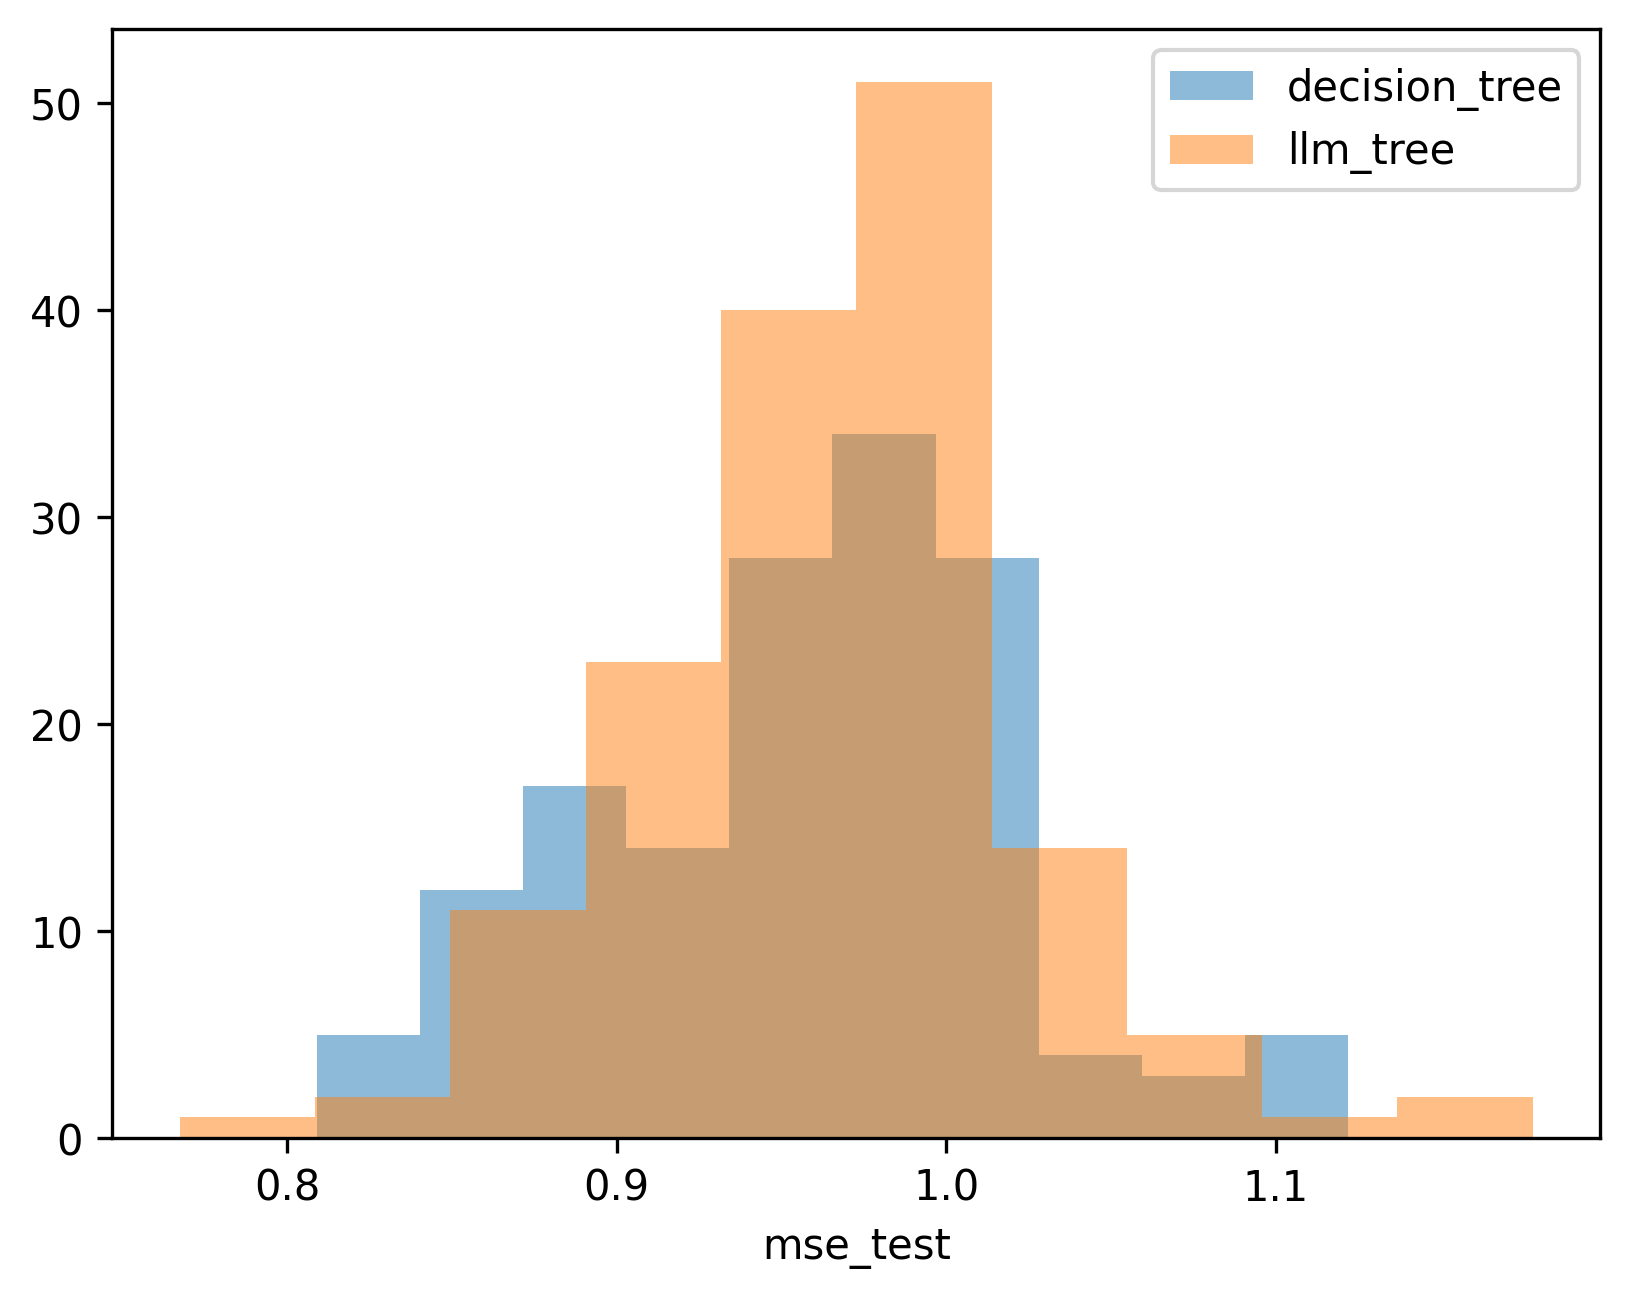

In [2]:
met = 'mse_test'
for model_name in ravg_cv.model_name.unique():
    rmodel = ravg_cv[ravg_cv.model_name == model_name]
    plt.hist(rmodel[met], label=model_name, alpha=0.5)
    plt.xlabel(met)
    print(model_name, np.mean(rmodel[met]).round(2))
plt.legend()
plt.show()

### Choose single model

In [41]:
rsing = r[r.n_estimators == 1]
rsing = rsing.sort_values(by='corr_test', ascending=False)
rsing = rsing[rsing.max_depth <= 2]
display(rsing.head())


# label_name==voxel_134, max_depth==2
run_args = rsing[(rsing.model_name == model_name) * (rsing.label_name == 'voxel_134') * (rsing.max_depth == 2)].iloc[0]
"""
Corr: 0.35
Stump(val=-0.01 n=[4785, 1553]) + you, yourself
   Stump(val=-0.07 n=[4654, 131]) + says, speaks, sings, calls, answers
      Neg n=4654 val=-0.083
      Pos n=131 val=0.533
   Stump(val=0.18 n=[1510, 43]) + yeah, sure, definitely
      Neg n=1510 val=0.154
      Pos n=43 val=0.907
"""

# label_name==voxel_31, max_depth==2
# run_args = rsing[(rsing.model_name == model_name) * (rsing.label_name == 'voxel_31') * (rsing.max_depth == 2)].iloc[0]
"""
Corr: 0.36
Stump(val=-0.02 n=[5353, 985]) + me, my identity
   Stump(val=-0.06 n=[5178, 175]) + says, speaks, screams, sings, calls
      Neg n=5178 val=-0.073
      Pos n=175 val=0.423
   Stump(val=0.17 n=[981, 4]) + says really
      Neg n=981 val=0.162
      Pos n=4 val=1.816
"""

# idx = 5
# run_args = rsing[(rsing.model_name == model_name)].iloc[idx]

print(f'met {run_args["corr_test"]:0.2f}', 'depth', run_args.max_depth)
model = pkl.load(open(join(run_args.save_dir_unique, 'model.pkl'), 'rb'))
print(model)
# print(run_args)

,dataset_name,subsample_frac,ngrams,use_stemming,label_name,seed,save_dir,model_name,n_estimators,max_depth,...,feature_names,r2_train,mse_train,corr_train,r2_cv,mse_cv,corr_cv,r2_test,mse_test,corr_test
343,csinva/fmri_language_responses,1,2,0,voxel_81,1,/home/chansingh/llm-tree/results/fmri_mar3,decision_tree,1,2,...,"[', ' auntie, ' dorm, ' hair, ' house, ' house...",0.017218,0.975911,0.131218,0.003811,1.010279,0.081597,0.131974,0.868026,0.445701
423,csinva/fmri_language_responses,1,2,0,voxel_22,1,/home/chansingh/llm-tree/results/fmri_mar3,decision_tree,1,2,...,"[', ' auntie, ' dorm, ' hair, ' house, ' house...",0.022611,0.973217,0.150370,0.010682,0.996945,0.112366,0.132315,0.867685,0.441786
637,csinva/fmri_language_responses,1,2,0,voxel_22,1,/home/chansingh/llm-tree/results/fmri_mar3,llm_tree,1,2,...,"[', ' auntie, ' dorm, ' hair, ' house, ' house...",0.026003,0.969840,0.161254,0.011629,0.995991,0.117814,0.136248,0.863752,0.441748
13,csinva/fmri_language_responses,1,2,0,voxel_42,1,/home/chansingh/llm-tree/results/fmri_mar3,decision_tree,1,2,...,"[', ' auntie, ' dorm, ' hair, ' house, ' house...",0.014565,0.979257,0.120684,0.006954,1.005590,0.085901,0.107313,0.892687,0.420311
995,csinva/fmri_language_responses,1,2,0,voxel_38,1,/home/chansingh/llm-tree/results/fmri_mar3,decision_tree,1,2,...,"[', ' auntie, ' dorm, ' hair, ' house, ' house...",0.018124,0.992809,0.134625,0.005409,0.972061,0.088406,0.125871,0.874129,0.415751


met 0.35 depth 2
> Tree(max_depth=2 max_features=1 refine=llm)
> ------------------------------------------------------
Stump(val=-0.01 n=[4785, 1553]) + you, yourself
   Stump(val=-0.07 n=[4654, 131]) + says, speaks, sings, calls, answers
      Neg n=4654 val=-0.083
      Pos n=131 val=0.533
   Stump(val=0.18 n=[1510, 43]) + yeah, sure, definitely
      Neg n=1510 val=0.154
      Pos n=43 val=0.907



# Analyze models

### Load an individual model

model_name decision_tree
met 0.41 depth 4


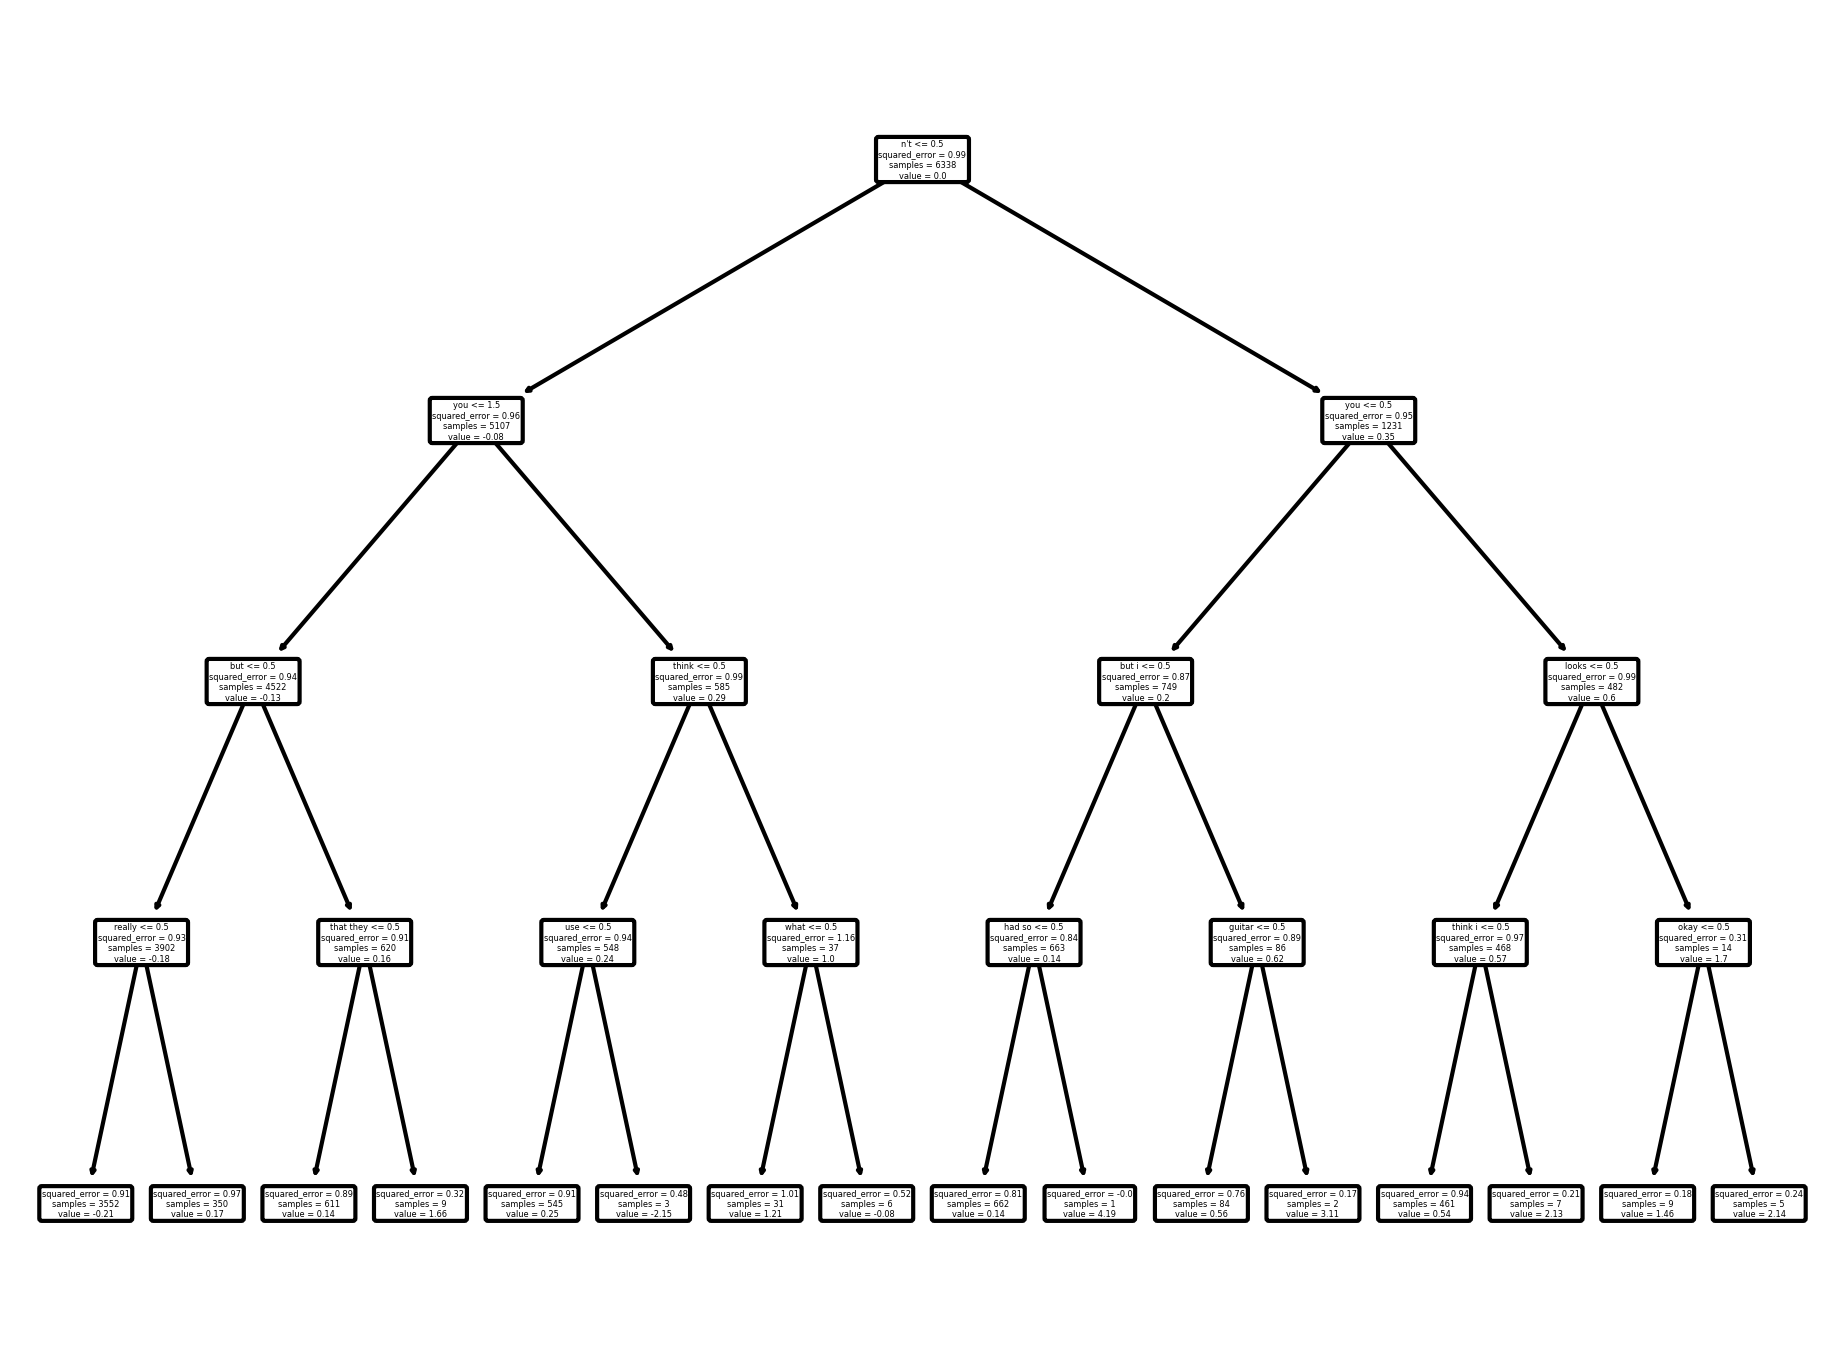

In [24]:
# for model_name in ['llm_tree']:
met = 'corr' + '_test'
rd = r
for model_name in ['decision_tree']:
    print('model_name', model_name)
    run_args = rd[(rd.model_name == model_name)].sort_values(by=met).iloc[-2]
    # run_args = rd[(rd.model_name == 'llm_tree')].sort_values(by='max_depth').iloc[-1]

    print(f'met {run_args[met]:0.2f}', 'depth', run_args.max_depth)
    model = pkl.load(open(join(run_args.save_dir_unique, 'model.pkl'), 'rb'))


    if model_name == 'llm_tree':
        dt, feature_names = imodelsx.viz.extract_sklearn_tree_from_llm_tree(model, n_classes=2, dtreeviz_dummies=False)
        print(model)
        print(feature_names)
    else:
        dt = model
        feature_names = run_args.feature_names
    feat_names = ['\n'.join(n.split(',')) for n in feature_names]
    sklearn.tree.plot_tree(dt, feature_names=feat_names, class_names=['neg', 'pos'],
                            precision=2, rounded=True)
    plt.show()
    # print(sklearn.tree.export_text(dt, feature_names=feat_names))

In [25]:
importances = dt.feature_importances_
tree_importances = pd.Series(importances, index=feature_names)
tree_importances = tree_importances[tree_importances > 0]
tree_importances.sort_values(ascending=False).head(30)

n't          0.324346
you          0.236519
but          0.104345
really       0.077773
that they    0.035156
think        0.034709
looks        0.030237
think i      0.030076
but i        0.029988
use          0.029705
had so       0.028222
guitar       0.021810
what         0.014508
okay         0.002606
dtype: float64

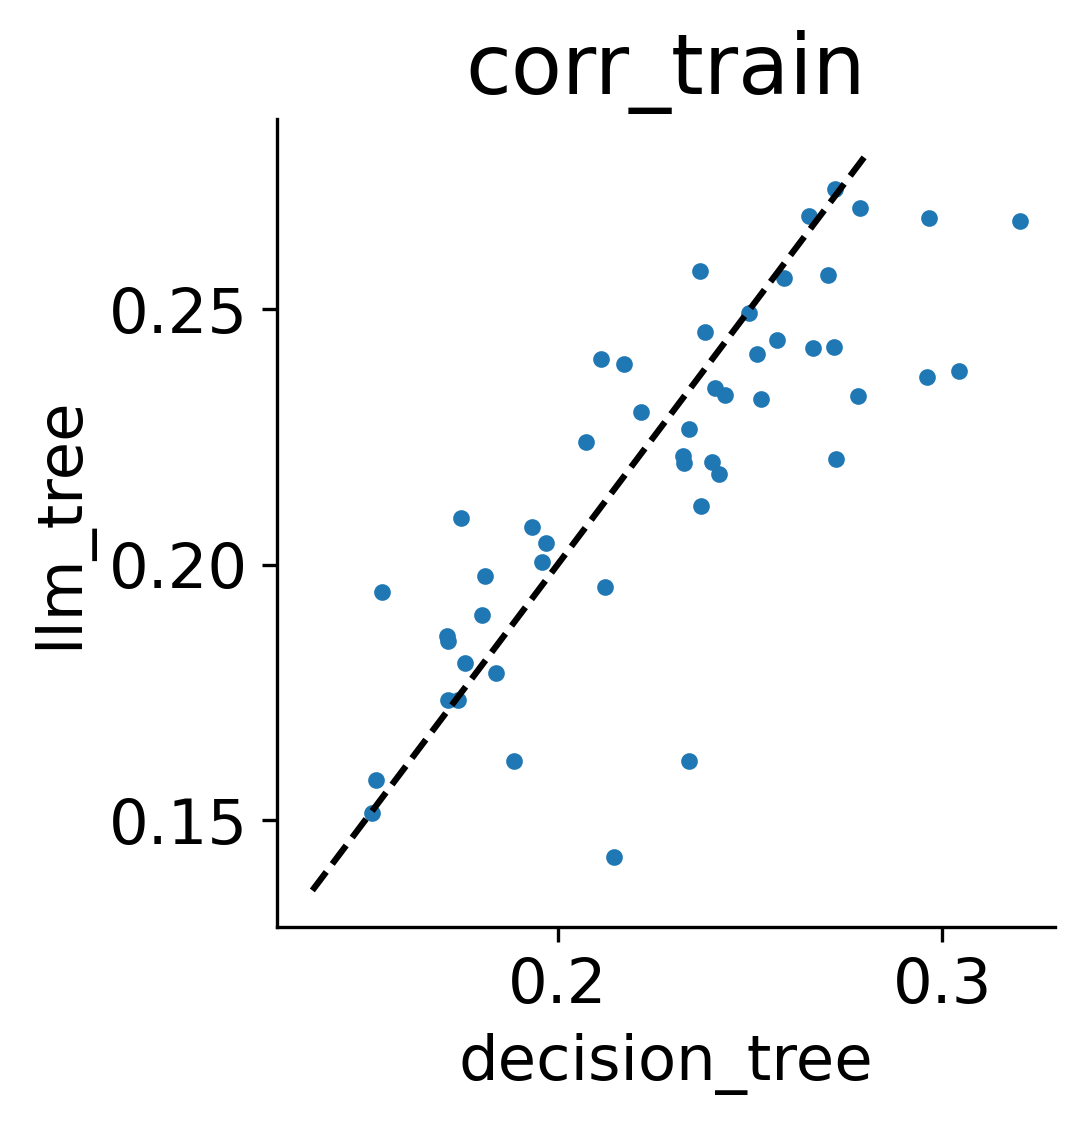

In [27]:
res_dict = {
    'decision_tree': [],
    'llm_tree': [],
}
met = 'corr_train'
for (k, group) in ravg_cv.groupby(by='label_name'):
    # print(k, group.shape)
    if len(group) == 2:
        for k in res_dict.keys():
            res_dict[k].append(group[group['model_name'] == k][met].values[0])
x = res_dict['decision_tree']
y = res_dict['llm_tree']
plt.figure(figsize=(4,4))
plt.plot(x, y, '.')
plt.xlabel('decision_tree')
plt.ylabel('llm_tree')
# plt.plot([0.1,0.5], [0.1,0.5], 'k--')
ymin, ymax = plt.gca().get_ylim()
plt.plot([ymin, ymax], [ymin, ymax], 'k--')
plt.title(met)
plt.show()